# DeepTrack + Copilot Analysis Demo

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Abhishek-Gupta-GitHub/confocal_microscopy-copilot/blob/main/notebooks/deeptrack_analysis_demo.ipynb)

This notebook shows how to:
- Generate synthetic 2D+t data with DeepTrack (or a fallback).
- Run DeepTrack-based detection + Trackpy tracking via the copilot.
- Analyze trajectories with `PhysicsAnalystAdvanced`.
- Compare to your existing digital twin synthetic data.

In [1]:
import os, sys

# If running from VS Code inside the repo:
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..")) if os.path.basename(os.getcwd()) == "notebooks" else os.getcwd()
print("Repo root:", repo_root)

if repo_root not in sys.path:
    sys.path.insert(0, repo_root)


Repo root: c:\Users\akumarg\Desktop\microscopy hackathon\confocal_microscopy-copilot


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from copilot.detection_deeptrack import DeepTrackDetector, DeepTrackConfig
from src.analysis.physics_analyst_basic import Trajectory
from copilot.digital_twin import DigitalTwin
from copilot.orchestrator import Orchestrator
from src.analysis.physics_analyst_advanced import PhysicsAnalystAdvanced  # or your current module
from copilot.config import DEFAULT_META


C:\Users\akumarg\AppData\Roaming\Python\Python311\site-packages\deeptrack\__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


Generate DeepTrack synthetic 2D+t (code)

Synthetic DeepTrack stack shape (T, H, W): (100, 64, 64)


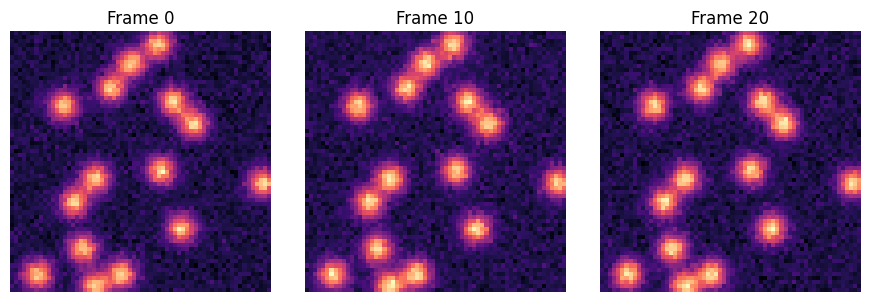

In [3]:
dt_cfg = DeepTrackConfig(image_shape=(64, 64), particle_radius_px=2.5)
dt_detector = DeepTrackDetector(dt_cfg)

stack_2d_t = dt_detector.generate_synthetic_2d_t(n_frames=100)
print("Synthetic DeepTrack stack shape (T, H, W):", stack_2d_t.shape)


# Quick visualization of a few frames
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, ax in enumerate(axes):
    ax.imshow(stack_2d_t[i * 10], cmap="magma")
    ax.set_title(f"Frame {i * 10}")
    ax.axis("off")
plt.tight_layout()
plt.show()


Wrap 2D+t into fake 3D stack for copilot (code)

In [4]:
# Your copilot expects 3D stacks (T, Z, H, W). Wrap 2D as Z=1 slice.
T, H, W = stack_2d_t.shape
stack_3d = stack_2d_t[:, None, :, :]  # shape (T, 1, H, W)

print("Wrapped stack_3d shape:", stack_3d.shape)


Wrapped stack_3d shape: (100, 1, 64, 64)


Plan via Orchestrator (code)

In [5]:
from copilot.agents import Plan  # or wherever Plan lives

orchestrator = Orchestrator()
user_question = "Analyze diffusion and heterogeneity in this DeepTrack synthetic dataset."
plan = orchestrator.make_plan(
    stack_shape=stack_3d.shape,
    meta=DEFAULT_META,
    user_question=user_question,
)
plan  # show fields


ModuleNotFoundError: No module named 'copilot.agents'

Detection + tracking using DeepTrack backend (code)

In [ ]:
det_worker = DetectionTrackingWorker()

dt_result = det_worker.run_with_deeptrack(stack_3d, plan)
trajectories = dt_result["trajectories"]
qm = dt_result["quality_metrics"]

print("Detection backend:", qm["backend"])
print("Number of tracks:", qm["n_tracks"])
print("Detections per frame (first 5):", dict(list(qm["detections_per_frame"].items())[:5]))


Visualize a few tracks (code)

In [ ]:
if len(trajectories) == 0:
    print("No trajectories to show.")
else:
    # Simple x–y scatter colored by time
    xs = np.array([traj.x for traj in trajectories])
    ys = np.array([traj.y for traj in trajectories])
    ts = np.array([traj.t for traj in trajectories])

    plt.figure(figsize=(4, 4))
    sc = plt.scatter(xs, ys, c=ts, s=5, cmap="viridis")
    plt.colorbar(sc, label="time (frame)")
    plt.gca().invert_yaxis()
    plt.xlabel("x [px]")
    plt.ylabel("y [px]")
    plt.title("DeepTrack-based trajectories (2D projection)")
    plt.tight_layout()
    plt.show()


PhysicsAnalystAdvanced on DeepTrack trajectories (code)

In [ ]:
# Assuming your PhysicsAnalystAdvanced takes (dt, pixel_size, dim, wall_z_threshold, etc.)
dt = 1.0  # arbitrary frame interval for synthetic DeepTrack example
pixel_size_um = DEFAULT_META["voxel_size_um"][0]

analyzer = PhysicsAnalystAdvanced(
    dt=dt,
    px_to_um=pixel_size_um,
    dim=2,
    wall_z_threshold=None,
)

summary = analyzer.summarize_physics(trajectories, domain="colloidal")
print("Keys in summary:", list(summary.keys()))
print("Flags:", summary.get("flags", {}))


MSD and heterogeneity plots (code)

# Adapt to your existing summary structure
msd = np.array(summary["msd"]["values"])
lags = np.array(summary["msd"]["lags"])
alpha = summary["msd"]["fit_exponent"]
D_est = summary["msd"]["D_estimate"]

plt.figure(figsize=(4, 4))
plt.loglog(lags, msd, "o-", label="MSD")
plt.loglog(lags, D_est * lags**alpha, "--", label=f"fit α={alpha:.2f}")
plt.xlabel("lag time")
plt.ylabel("MSD [µm²]")
plt.legend()
plt.title("DeepTrack synthetic: MSD")
plt.tight_layout()
plt.show()

# Example: non-Gaussian parameter if present
if "non_gaussian" in summary:
    lags_ng = np.array(summary["non_gaussian"]["lags"])
    alpha2 = np.array(summary["non_gaussian"]["alpha2"])
    plt.figure(figsize=(4, 3))
    plt.plot(lags_ng, alpha2, "o-")
    plt.xlabel("lag time")
    plt.ylabel(r"$\alpha_2$")
    plt.title("Non-Gaussian parameter")
    plt.tight_layout()
    plt.show()


Compare to DigitalTwin synthetic 3D+t (code)

# Use your existing twin to simulate a comparable 3D+t dataset
twin = DigitalTwin()
microscope_config = {
    "NA": 1.3,
    "wavelength_nm": 550.0,
    "immersion_ri": 1.518,
    "pixel_size_um": pixel_size_um,
    "z_step_um": DEFAULT_META["voxel_size_um"][2],
    "mode": "gaussian_confocal",
}
sample_config = {
    "object_type": "beads",
    "size_distribution": [3.0, 0.5],
    "brightness": 1.0,
    "volume_fraction": 0.1,
    "medium_type": "viscous",
    "wall_position_flag": False,
}

stack_twin = twin.simulate(microscope_config, sample_config, n_frames=100)
print("Twin stack shape:", stack_twin.shape)

# Reuse your “standard” DetectionTrackingWorker.run (not DeepTrack) + analyzer here.


## Notes and next steps

- This notebook demonstrates a DeepTrack-based path and a DigitalTwin-based path.
- You can extend `DeepTrackDetector` with:
  - 3D data generators (DeepTrack 3D PointParticle).
  - Trained CNN localizers from DeepTrack tutorials (DTEx212, DTEx213).  
- The same `PhysicsAnalystAdvanced` works for 2D, 2D+t, 3D, 3D+t as long as trajectories follow the unified schema.
